In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import scipy
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from cares_reinforcement_learning.util import plotter   

In [2]:
dir_list = ['SAC-CarBeat-24_10_12_23:18:59 (none) (opp_vel=1)',
            'SAC-CarBeat-24_10_12_23:18:35 (kalman_filter_ca) (opp_vel=1)',
            'SAC-CarBeat-24_10_13_01:54:06 (raw_marker_pose) (opp_vel=1)']
# dir_list = ['SAC-CarBeat-24_10_13_10:59:43 (none) (opp_vel=random)',
#             'SAC-CarBeat-24_10_13_11:10:54 (kalman_filter) (opp_vel=random)',
#             'SAC-CarBeat-24_10_13_02:13:32 (raw_marker_pose) (opp_vel=random)']

In [3]:
# Load eval.csv from each directory
dfs = {}

cwd = os.getcwd()

for _ in range(4):
    cwd = os.path.dirname(cwd)

training_logs_dir = os.path.join(cwd, 'training_logs')

for dir in dir_list:
    # df = pd.read_csv(os.path.join(training_logs_dir, dir, 'data/eval.csv'))
    df = pd.read_csv('/home/feifei/Downloads/training_logs/' + dir + '/data/eval.csv')
    dfs
    dfs[dir] = df

# dfs['SAC-CarBeat-24_10_12_23:18:35 (kalman_filter_ca) (opp_vel=1)'].head()

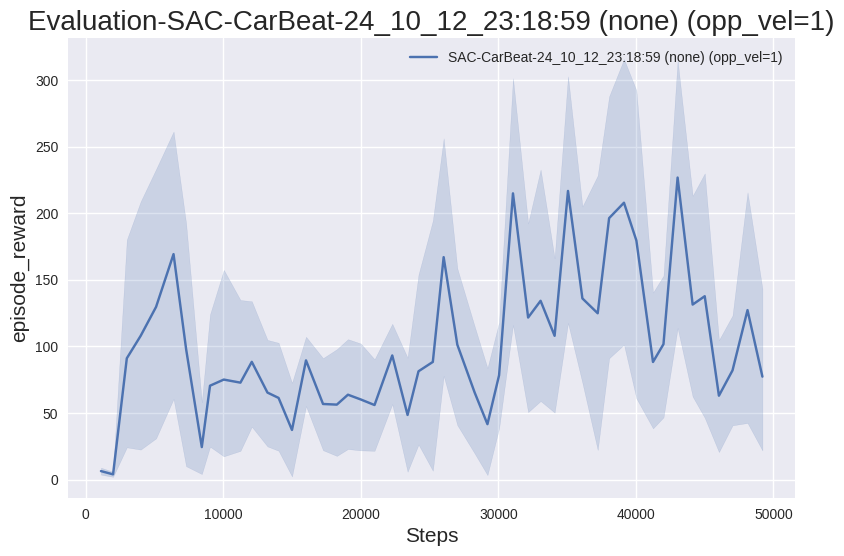

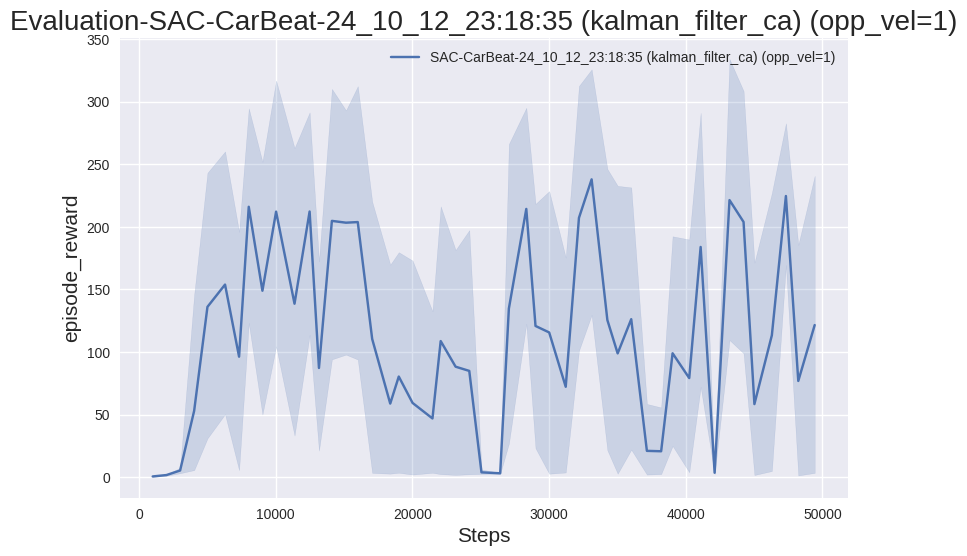

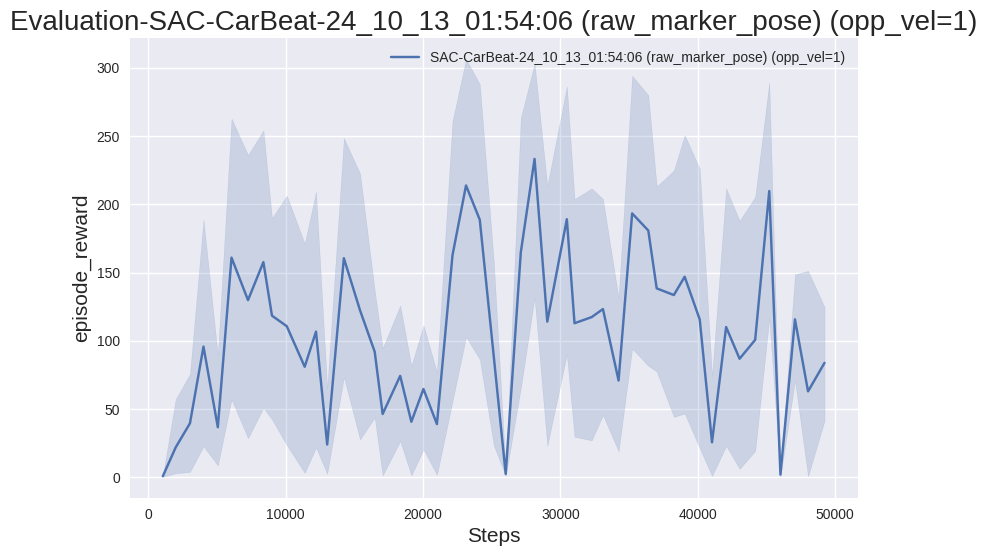

In [4]:
def plot_data(
    plot_frame: pd.DataFrame,
    title: str,
    metric: str,
    label: str,
    x_label: str,
    y_label: str,
    directory: str,
    filename: str,
    label_fontsize: int = 15,
    title_fontsize: int = 20,
    ticks_fontsize: int = 10,
    display: bool = True,
    close_figure: bool = True,
) -> None:
    # matplotlib.use("agg")

    # Plot Styles
    plt.style.use("seaborn-v0_8")

    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)

    plt.xticks(fontsize=ticks_fontsize)
    plt.yticks(fontsize=ticks_fontsize)

    sns.lineplot(
        data=plot_frame,
        x=plot_frame["total_steps"],
        y=metric,
        label=label
    )

    plt.legend(loc="best").set_draggable(True)

    plt.tight_layout(pad=0.5)

    if display:
        plt.show()

    if not os.path.exists(f"{directory}/figures"):
        os.makedirs(f"{directory}/figures")

    plt.savefig(f"{directory}/figures/{filename}.png")

    if close_figure:
        plt.close()

def plot_eval(
    eval_data: pd.DataFrame,
    title: str,
    label: str,
    directory: str,
    filename: str,
    metric: str = "episode_reward",
    display: bool = True,
) -> None:

    x_label: str = "Steps"
    y_label: str = metric

    plot_data(
        eval_data,
        title,
        metric,
        label,
        x_label,
        y_label,
        directory,
        filename,
        display=display,
    )

for dir in dir_list:
    plot_eval(
        dfs[dir],
        f"Evaluation-{dir}",
        f"{dir}",
        os.path.join(training_logs_dir, 'generated_plots'),
        f"eval-{dir}",
    )

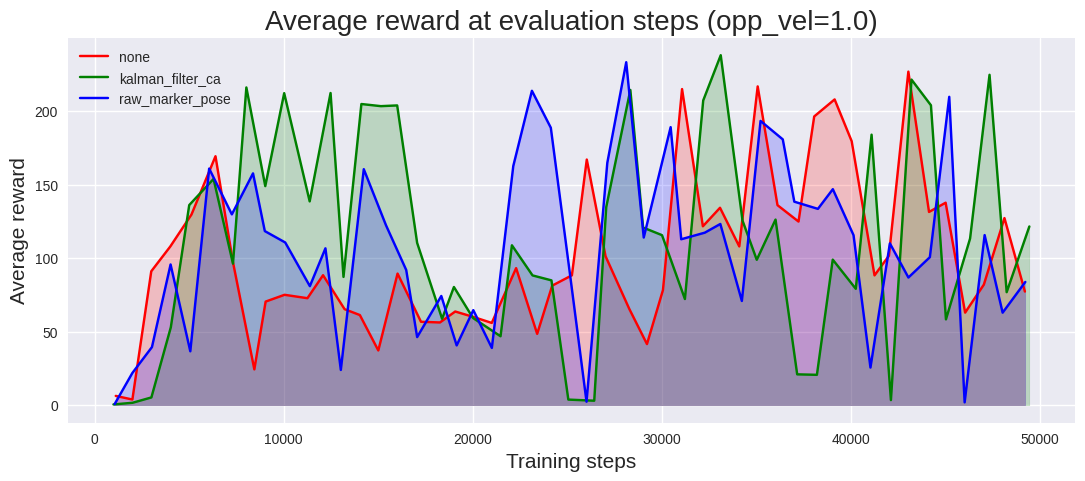

<Figure size 800x550 with 0 Axes>

In [5]:
# Now plot everything on the same figure

def plot_eval_same_figure(
    title: str,
    directory: str,
    filename: str,
    metric: str = "episode_reward",
    display: bool = True
) -> None:
    x_label: str = "Training steps"
    y_label: str = "Average reward"

    # Plot Styles
    plt.style.use("seaborn-v0_8")

    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    plt.title(title, fontsize=20)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.legend(loc="best").set_draggable(True)

    if not os.path.exists(f"{directory}/figures"):
        os.makedirs(f"{directory}/figures")
    
    count = 0
    colors = ['r', 'g', 'b']
    for dir in dir_list:
        eval_plot_frame = dfs[dir]
        # Average metric for each step
        eval_plot_frame = eval_plot_frame.groupby("total_steps").mean().reset_index()
        sns.lineplot(
            data=eval_plot_frame,
            x=eval_plot_frame["total_steps"],
            y=metric,
            label=dir.split(" (")[1].strip(")"),
            errorbar=None,
            color=colors[count]
        )
        
        # Completely fill the area under the curve
        plt.fill_between(
            eval_plot_frame["total_steps"],
            eval_plot_frame[metric],
            color=colors[count],
            alpha=0.2
        )
                    
        count += 1

    if display:
        plt.show()
    plt.savefig(f"{directory}/figures/{filename}.png")

plt.figure(figsize=(13, 5))

plot_eval_same_figure(
    f"Average reward at evaluation steps (opp_vel={dir_list[0].split('opp_vel=')[1].strip(')')})",
    os.path.join(training_logs_dir, 'generated_plots'),
    f"eval-same-figure",
)